<a href="https://colab.research.google.com/github/Justinezgh/SBI-Diff-Simulator/blob/u%2FJustinezgh%2FSNLE/notebooks/dev/SNLE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install --quiet jax-cosmo numpyro dm-haiku==0.0.5 optax
!pip install --quiet git+https://github.com/Justinezgh/SBI-Diff-Simulator.git

     |████████████████████████████████| 283 kB 4.2 MB/s 
     |████████████████████████████████| 292 kB 60.1 MB/s 
     |████████████████████████████████| 287 kB 28.0 MB/s 
     |████████████████████████████████| 145 kB 75.8 MB/s 
     |████████████████████████████████| 85 kB 4.8 MB/s 
     |████████████████████████████████| 128 kB 3.9 MB/s 


In [7]:
!pip install chainconsumer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.5 MB/s 
  Created wheel for chainconsumer: filename=ChainConsumer-0.34.0-py3-none-any.whl size=42779 sha256=2e2b5c73e39a1f3fd97054a503b1bd33a3887c79720566b935470ee4a1992a86
  Stored in directory: /root/.cache/pip/wheels/2d/e5/6c/c9b963aa8bafc25991c7ce2902ca81be7256746be0349137cf
Successfully built chainconsumer


In [8]:
!sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  cm-super-minimal fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre ghostscript gsfonts javascript-common
  libcupsfilters1 libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0
  libjs-jquery libkpathsea6 libpotrace0 libptexenc1 libruby2.5 libsynctex1
  libtexlua52 libtexluajit2 libzzip-0-13 lmodern pfb2t1c2pfb poppler-data
  preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-latex-base texlive-latex-recommended
  texlive-pictures texlive-plain-generic tipa
Suggested packages:
  fonts-noto ghostscript-x apach

In [1]:
import logging
# Removing annoying TFP error message
logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import argparse
import pickle
from functools import partial

import optax
import haiku as hk
import numpy as np
import jax
import jax.numpy as jnp
from numpyro.handlers import condition

import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax
tfb = tfp.bijectors
tfd = tfp.distributions


from sbids.metrics.c2st import c2st
from sbids.tasks import (
  lotka_volterra, lotka_volterra_y_bijector, 
  lotka_volterra_theta_bijector, get_samples_and_scores
)
from sbids.models import AffineSigmoidCoupling, ConditionalRealNVP

/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


In [3]:
from chainconsumer import ChainConsumer

In [5]:
# create model compressor 
class Compressor(hk.Module):

  def __call__(self, x):
    
    x = x/1000
    x = x[..., jnp.newaxis]

    net_x = hk.Conv1D(32, 3, 1)(x) 
    net_x = jax.nn.leaky_relu(net_x) 
    net_x = hk.Conv1D(64, 4, 2)(net_x) 
    net_x = jax.nn.leaky_relu(net_x) 
    net_x = hk.Conv1D(128, 3, 1)(net_x)
    net_x = jax.nn.leaky_relu(net_x) 
    net_x = hk.Flatten()(net_x) 
    
    net_x = hk.Linear(32)(net_x) 
    net_x = jax.nn.leaky_relu(net_x) 
    net_x = hk.Linear(16)(net_x) 
    net_x = jax.nn.leaky_relu(net_x) 
    net_x = hk.Linear(4)(net_x) 

    return net_x.squeeze()

bijector_layers_compressor = [128] * 2

bijector_compressor = partial(
  AffineSigmoidCoupling, 
  layers=bijector_layers_compressor, 
  n_components=16, 
  activation=jax.nn.silu
)

NF_compressor = partial(
  ConditionalRealNVP, 
  n_layers=3, 
  bijector_fn=bijector_compressor)


class Flow_nd_Compressor(hk.Module):
    def __call__(self, y):
        nvp = NF_compressor(4)(y)
        return tfd.TransformedDistribution(nvp,
                                           tfb.Chain([tfb.Invert(lotka_volterra_theta_bijector),
                                                      tfb.Scale(30.),
                                                      tfb.Shift(-0.5)]))

# compressor
compressor = hk.without_apply_rng(hk.transform(lambda x : Compressor()(x)))
# nf
nf = hk.without_apply_rng(hk.transform(lambda p,x : Flow_nd_Compressor()(x).log_prob(p).squeeze()))

a_file = open("/content/params_compressor4.pkl", "rb")
parameters_compressor = pickle.load(a_file)

# reg = compressor.apply(parameters_compressor,batch)
scale_reg = jnp.array([ 6.233213, 13.966835, 13.656771,  7.450791]) #(jnp.std(reg, axis =0)/0.04)
shift_reg = jnp.array([-0.4551523,  -0.48648357, -0.50399256, -0.4354317 ])#jnp.mean(reg/scale_reg, axis = 0)-0.5



In [6]:
## create model 
from functools import partial
bijector_layers = [128] * 2

bijector_npe = partial(
  AffineSigmoidCoupling, 
  layers=bijector_layers, 
  n_components=16, 
  activation=jax.nn.silu
)

NF_npe = partial(
  ConditionalRealNVP, 
  n_layers=4, 
  bijector_fn=bijector_npe)


class SmoothNLE(hk.Module):
    def __call__(self, theta):
        transfo = tfb.Chain([tfb.Invert(lotka_volterra_theta_bijector),tfb.Scale(30.),tfb.Shift(-0.5)])
        net = transfo.inverse(theta)
        nvp = NF_npe(4)(net)
        return tfd.TransformedDistribution(nvp,
                                           tfb.Chain([tfb.Scale(scale_reg), tfb.Shift(shift_reg)]))

nvp_nd = hk.without_apply_rng(hk.transform(lambda theta,y : SmoothNLE()(theta).log_prob(y).squeeze()))

In [7]:
# define loss function and model update
def loss_fn(params, weight, mu, batch, score):
  y = compressor.apply(parameters_compressor, batch)
  log_prob, out = jax.vmap(
    jax.value_and_grad(lambda theta, x: nvp_nd.apply(params, theta.reshape([1,4]), x.reshape([1,4])).squeeze())
    )(mu, y)
    
  return -jnp.mean(log_prob) +  jnp.mean(weight * jnp.sum((out - score)**2, axis=1)) 

@jax.jit
def update(params, opt_state, weight, mu, batch, score):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params, weight, mu, batch, score)
    updates, new_opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
  
    return loss, new_params, new_opt_state


In [8]:
# create truth
seed_for_truth = 0
model = lotka_volterra
(log_probs, samples), scores = get_samples_and_scores(model, jax.random.PRNGKey(seed_for_truth), batch_size=1)
truth, observation = samples['theta'], samples['y'].reshape([-1,20],order='F')
reference_samples = jnp.load('/content/reference_sample_seed%d.npy' % seed_for_truth)

obs = compressor.apply(parameters_compressor, observation.reshape([1,20]))

/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:206: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, structure = jax.tree_flatten(mapping)


In [16]:
R = 3
seq = 1
start_grad = 1

batch_size=256
n_simulations=100
n_steps=20000
score_weight=0
initial_learning_rate=0.002

model_seed=0
rng_seq = hk.PRNGSequence(model_seed)

In [17]:
from tqdm import tqdm

/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:206: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, structure = jax.tree_flatten(mapping)
  0%|          | 0/20000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:214: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  self._mapping = jax.tree_unflatten(self._structure, self._leaves)
/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:206: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, structure = jax.tree_flatten(mapping)
100%|██████████| 20000/20000 [13:54<00:00, 23.97it/s]
/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:214: FutureWarning: jax.tree_unflatten is deprecated, and will

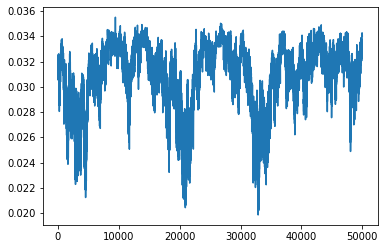

In [18]:
  batch_loss_round_0 = []
  c2st_metric_round_0 = []
  sample_for_plot_round_0 = []
  score_weight = 0

  rounds = 0


  if rounds == 0: 
    sample = {}
    thetas = None

  elif seq == 0 : 
    thetas = None


  @jax.jit
  def get_batch(key, batch_size=n_simulations):
      model = lotka_volterra
      (log_probs, samples), scores = get_samples_and_scores(model, key, batch_size=batch_size, score_type='conditional', thetas = thetas)
      return samples['theta'], samples['y'].reshape([-1,20], order='F'), scores

  thetas, batch, score = get_batch(jax.random.PRNGKey(rounds)) 

  # just in case..
  if jnp.isnan(score).any() == True:
    idx = jnp.where(jnp.isnan(score))[0]
    batch = jnp.delete(batch, idx, axis=0)
    thetas = jnp.delete(thetas, idx, axis=0)
    score = jnp.delete(score, idx, axis=0)

  if rounds == 0: 
    sample['thetas'] = thetas
    sample['batch'] = batch
    sample['score'] = score
    sample['round'] = jnp.repeat(rounds, len(score))
  else :
    sample['thetas'] = np.concatenate((sample['thetas'], thetas))
    sample['batch'] = np.concatenate((sample['batch'], batch))
    sample['score'] = np.concatenate((sample['score'], score))
    sample['round'] = np.concatenate((sample['round'], jnp.repeat(rounds, len(score))))


  # init parameters
  rng_seq = hk.PRNGSequence(model_seed)
  if rounds == 0:
    params_nd = nvp_nd.init(next(rng_seq),  0.5*jnp.ones([1,4]), 0.5*jnp.ones([1,4]))

  # init optimizer
  scheduler = optax.exponential_decay(init_value=0.001, transition_steps=1000, decay_rate=0.9, end_value=0.00001)
  optimizer = optax.chain(optax.scale_by_adam(), optax.scale_by_schedule(scheduler), optax.scale(-1))
  opt_state = optimizer.init(params_nd)


  # train
  for step in tqdm(range(n_steps)): 
    inds = np.random.randint(0, len(sample['thetas']), batch_size) 
    
    inds_not_grad = jnp.where(sample['round'][inds] < start_grad)
    weight = np.repeat(score_weight, len(inds))
    weight[inds_not_grad] = 0

    l, params_nd, opt_state = update(params_nd, opt_state, weight, sample['thetas'][inds], sample['batch'][inds], sample['score'][inds])
    if jnp.isnan(l):
      break
    
    batch_loss_round_0.append(l)

  #mcmc
  import tensorflow as tf
  with tf.device('/CPU:0'):
    def unnormalized_log_prob(x):
            likelihood = nvp_nd.apply(params_nd, x.reshape([-1, 4]), obs.reshape([-1, 4])).squeeze()
            prior = tfd.LogNormal(loc=jnp.array([-0.125,-3,-0.125,-3]),
                                  scale=jnp.array([0.5, 0.5, 0.5, 0.5])).log_prob(x).sum()
            return likelihood + prior

        
    sample_nd = []
    j = 0

    nb_simulations_needed = 10000
    if n_simulations > 10000: 
      nb_simulations_needed = n_simulations

    count = 0
    while len(sample_nd) < nb_simulations_needed :
      count+=1
      num_results_size = 5 + j
      # Initialize the HMC transition kernel.
      num_results = int(nb_simulations_needed * num_results_size) 
      num_burnin_steps = int(4e3)
      adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
          tfp.mcmc.HamiltonianMonteCarlo(
              target_log_prob_fn=unnormalized_log_prob,
              num_leapfrog_steps=3,
              step_size=0.01),
          num_adaptation_steps=int(num_burnin_steps * 0.8))

      # Run the chain (with burn-in).
      @jax.jit
      def run_chain():
        samples, is_accepted = tfp.mcmc.sample_chain(
            num_results=num_results,
            num_burnin_steps=num_burnin_steps,
            current_state=jnp.array(truth),
            kernel=adaptive_hmc,
            trace_fn=lambda _, pkr: pkr.inner_results.is_accepted,
            seed = jax.random.PRNGKey(j))
              
        return samples, is_accepted


      samples_hmc, is_accepted_hmc = run_chain()
      plt.clf()
      plt.plot(samples_hmc[:,0,1])
      plt.savefig('chain_round_%d' %rounds)

      sample_nd = samples_hmc[is_accepted_hmc].reshape([-1,4])

      if count > 5:
        break

      j += 5

  # compute metric c2st
  if len(sample_nd) > 10000 : 
     inds = np.random.randint(0, len(sample_nd),  10000) 
     sample_nd_for_c2st = sample_nd[inds,...]
      
  if len(sample_nd) > n_simulations : 
       inds = np.random.randint(0, len(sample_nd),  n_simulations) 
       thetas = sample_nd[inds,...]

  c2st_metric_round_0.append(c2st(reference_samples, sample_nd_for_c2st, seed=0, n_folds=5))

  sample_for_plot_round_0.append(sample_nd_for_c2st)



In [19]:
params_round_0 = params_nd

Text(0.5, 1.0, 'loss nf round 0')

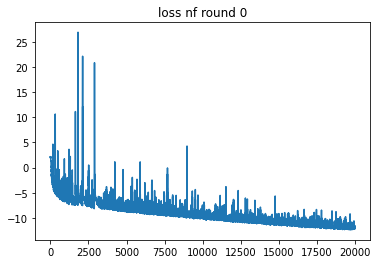

In [20]:
plt.plot(batch_loss_round_0)
plt.title('loss nf round 0')

Text(0.5, 1.0, 'mcmc chain round 0')

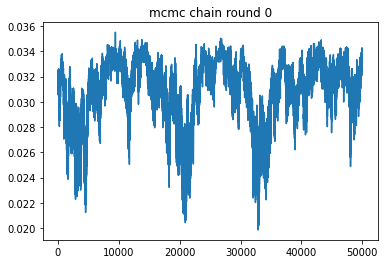

In [21]:
plt.plot(samples_hmc[:,0,1])
plt.title('mcmc chain round 0')

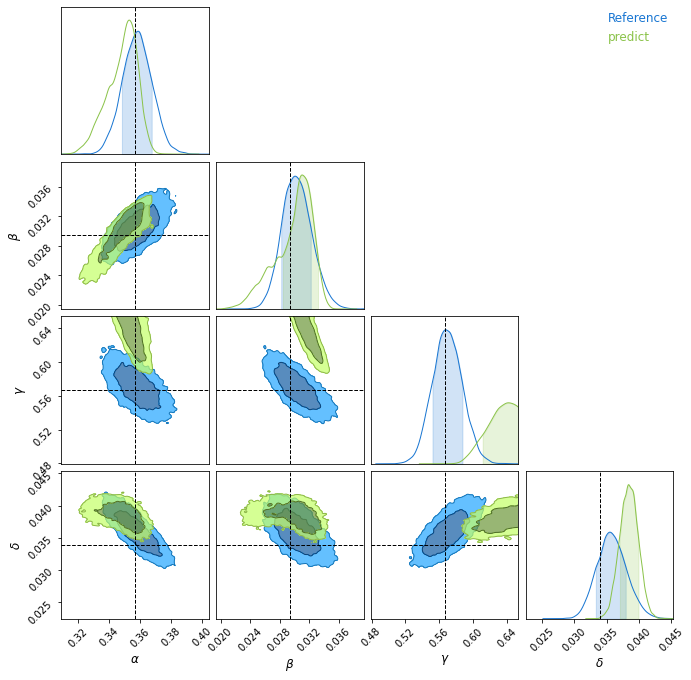

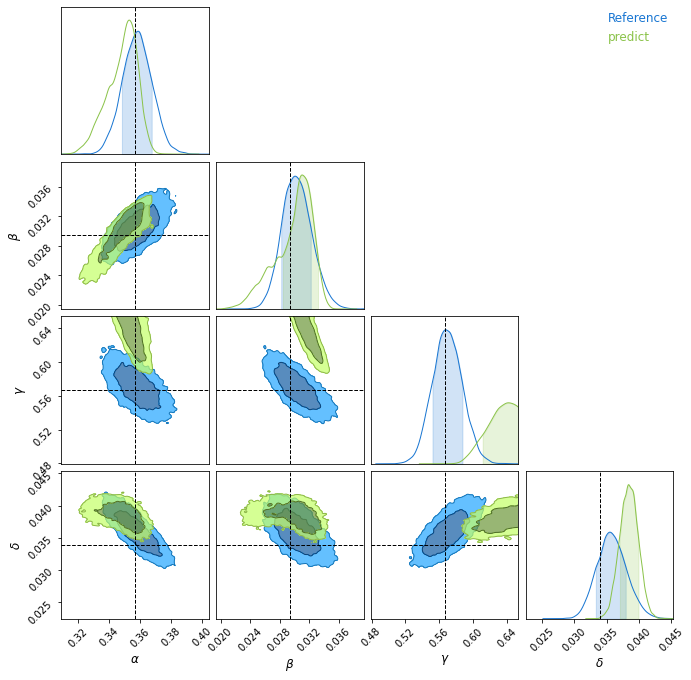

In [22]:
#plot first round
parameters = [r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\delta$']
c = ChainConsumer()
c.add_chain(jnp.array(reference_samples), parameters=parameters, name="Reference")
c.add_chain(sample_for_plot_round_0[0], name="predict")
c.plotter.plot(
    figsize=[10, 10], 
    truth=np.array(truth)[0], 
    extents=[[t - 5 * np.std(reference_samples[:,i]), 
              t + 5 * np.std(reference_samples[:,i])] for i,t in enumerate(truth[0])]
  )

100%|██████████| 20000/20000 [09:26<00:00, 35.31it/s]
/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:214: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  self._mapping = jax.tree_unflatten(self._structure, self._leaves)
/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:206: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, structure = jax.tree_flatten(mapping)
/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:206: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, structure = jax.tree_flatten(mapping)
100%|██████████| 20000/20000 [09:34<00:00, 34.83it/s]
/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:214: FutureWarning: jax.tree_unflatten is depreca

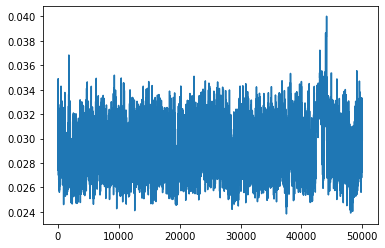

In [23]:
batch_loss_round_1_without_score = []
c2st_metric_round_1_without_score = []
sample_for_plot_round_1_without_score = []
score_weight = 0

params_nd = params_round_0

for rounds in [1,2]:

  ## create simulations
  if rounds == 0: 
    sample = {}
    thetas = None

  elif seq == 0 : 
    thetas = None


  @jax.jit
  def get_batch(key, batch_size=n_simulations):
      model = lotka_volterra
      (log_probs, samples), scores = get_samples_and_scores(model, key, batch_size=batch_size, score_type='conditional', thetas = thetas)
      return samples['theta'], samples['y'].reshape([-1,20], order='F'), scores

  thetas, batch, score = get_batch(jax.random.PRNGKey(rounds)) 

  # just in case..
  if jnp.isnan(score).any() == True:
    idx = jnp.where(jnp.isnan(score))[0]
    batch = jnp.delete(batch, idx, axis=0)
    thetas = jnp.delete(thetas, idx, axis=0)
    score = jnp.delete(score, idx, axis=0)

  if rounds == 0: 
    sample['thetas'] = thetas
    sample['batch'] = batch
    sample['score'] = score
    sample['round'] = jnp.repeat(rounds, len(score))
  else :
    sample['thetas'] = np.concatenate((sample['thetas'], thetas))
    sample['batch'] = np.concatenate((sample['batch'], batch))
    sample['score'] = np.concatenate((sample['score'], score))
    sample['round'] = np.concatenate((sample['round'], jnp.repeat(rounds, len(score))))


  # init parameters
  rng_seq = hk.PRNGSequence(model_seed)
  # if rounds == 0:
  #   params_nd = nvp_nd.init(next(rng_seq),  0.5*jnp.ones([1,4]), 0.5*jnp.ones([1,4]))

  # init optimizer
  scheduler = optax.exponential_decay(init_value=0.001, transition_steps=1000, decay_rate=0.9, end_value=0.00001)
  optimizer = optax.chain(optax.scale_by_adam(), optax.scale_by_schedule(scheduler), optax.scale(-1))
  opt_state = optimizer.init(params_nd)


  # train
  for step in tqdm(range(n_steps)): 
    inds = np.random.randint(0, len(sample['thetas']), batch_size) 
    
    inds_not_grad = jnp.where(sample['round'][inds] < start_grad)
    weight = np.repeat(score_weight, len(inds))
    weight[inds_not_grad] = 0

    l, params_nd, opt_state = update(params_nd, opt_state, weight, sample['thetas'][inds], sample['batch'][inds], sample['score'][inds])
    if jnp.isnan(l):
      break
    
    batch_loss_round_1_without_score.append(l)

  #mcmc
  import tensorflow as tf
  with tf.device('/CPU:0'):
    def unnormalized_log_prob(x):
            likelihood = nvp_nd.apply(params_nd, x.reshape([-1, 4]), obs.reshape([-1, 4])).squeeze()
            prior = tfd.LogNormal(loc=jnp.array([-0.125,-3,-0.125,-3]),
                                  scale=jnp.array([0.5, 0.5, 0.5, 0.5])).log_prob(x).sum()
            return likelihood + prior

        
    sample_nd = []
    j = 0

    nb_simulations_needed = 10000
    if n_simulations > 10000: 
      nb_simulations_needed = n_simulations

    count = 0
    while len(sample_nd) < nb_simulations_needed :
      count+=1
      num_results_size = 5 + j
      # Initialize the HMC transition kernel.
      num_results = int(nb_simulations_needed * num_results_size) 
      num_burnin_steps = int(4e3)
      adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
          tfp.mcmc.HamiltonianMonteCarlo(
              target_log_prob_fn=unnormalized_log_prob,
              num_leapfrog_steps=3,
              step_size=0.01),
          num_adaptation_steps=int(num_burnin_steps * 0.8))

      # Run the chain (with burn-in).
      @jax.jit
      def run_chain():
        samples, is_accepted = tfp.mcmc.sample_chain(
            num_results=num_results,
            num_burnin_steps=num_burnin_steps,
            current_state=jnp.array(truth),
            kernel=adaptive_hmc,
            trace_fn=lambda _, pkr: pkr.inner_results.is_accepted,
            seed = jax.random.PRNGKey(j))
              
        return samples, is_accepted


      samples_hmc, is_accepted_hmc = run_chain()
      plt.clf()
      plt.plot(samples_hmc[:,0,1])
      plt.savefig('chain_round_%d' %rounds)

      sample_nd = samples_hmc[is_accepted_hmc].reshape([-1,4])

      if count > 5:
        break

      j += 5
        


  # compute metric c2st
  if len(sample_nd) > 10000 : 
     inds = np.random.randint(0, len(sample_nd),  10000) 
     sample_nd_for_c2st = sample_nd[inds,...]
      
  if len(sample_nd) > n_simulations : 
       inds = np.random.randint(0, len(sample_nd),  n_simulations) 
       thetas = sample_nd[inds,...]

  c2st_metric_round_1_without_score.append(c2st(reference_samples, sample_nd_for_c2st, seed=0, n_folds=5))

  sample_for_plot_round_1_without_score.append(sample_nd_for_c2st)

params_round3_withtout_score = params_nd

Text(0.5, 1.0, 'loss nf round 1 and 2 without score')

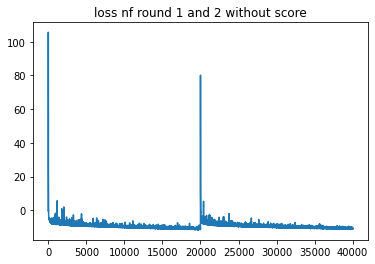

In [24]:
plt.plot(batch_loss_round_1_without_score)
plt.title('loss nf round 1 and 2 without score')

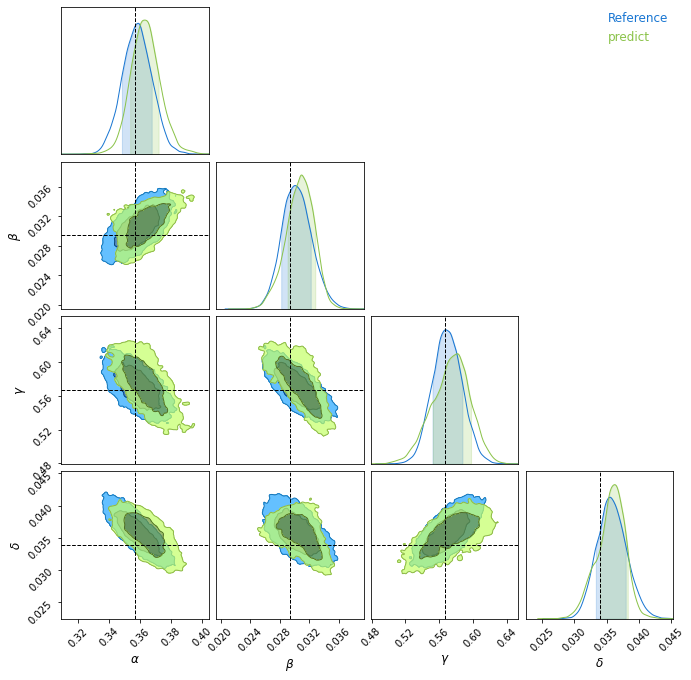

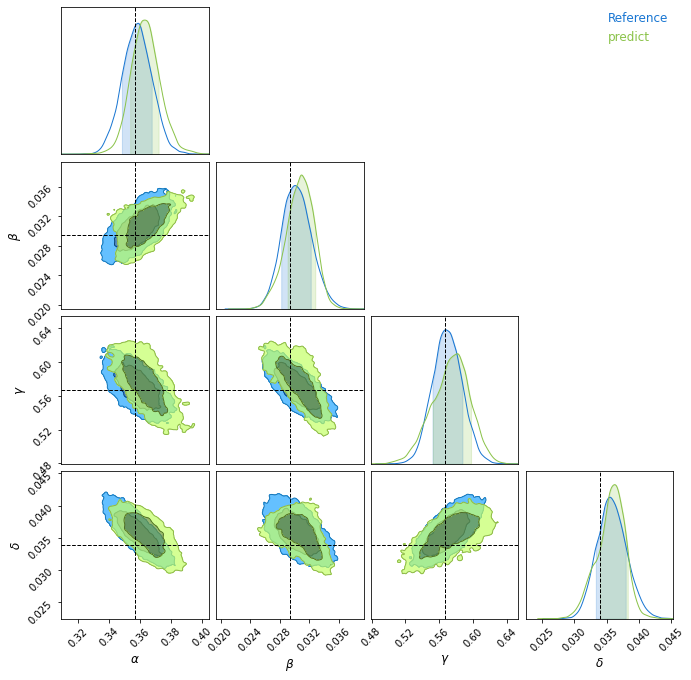

In [25]:
#plot second round without score
parameters = [r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\delta$']
c = ChainConsumer()
c.add_chain(jnp.array(reference_samples), parameters=parameters, name="Reference")
c.add_chain(sample_for_plot_round_1_without_score[0], parameters=parameters, name="predict")
c.plotter.plot(
    figsize=[10, 10], 
    truth=np.array(truth)[0], 
    extents=[[t - 5 * np.std(reference_samples[:,i]), 
              t + 5 * np.std(reference_samples[:,i])] for i,t in enumerate(truth[0])]
  )

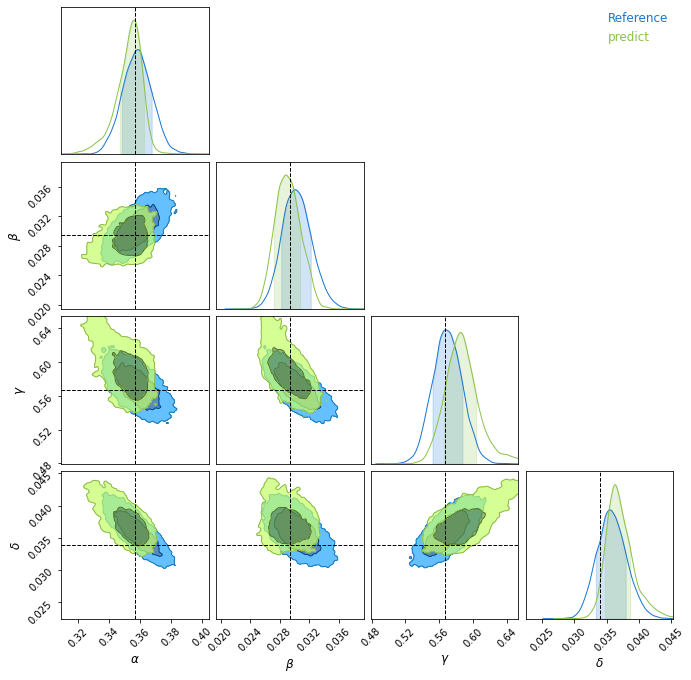

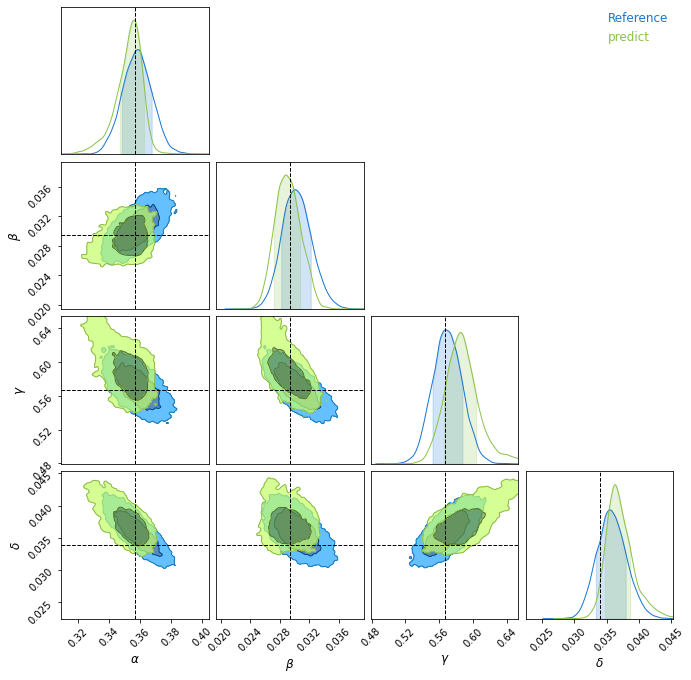

In [26]:
#plot third round without score
parameters = [r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\delta$']
c = ChainConsumer()
c.add_chain(jnp.array(reference_samples), parameters=parameters, name="Reference")
c.add_chain(sample_for_plot_round_1_without_score[1], parameters=parameters, name="predict")
c.plotter.plot(
    figsize=[10, 10], 
    truth=np.array(truth)[0], 
    extents=[[t - 5 * np.std(reference_samples[:,i]), 
              t + 5 * np.std(reference_samples[:,i])] for i,t in enumerate(truth[0])]
  )

100%|██████████| 20000/20000 [09:23<00:00, 35.46it/s]
/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:214: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  self._mapping = jax.tree_unflatten(self._structure, self._leaves)
/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:206: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, structure = jax.tree_flatten(mapping)
/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:206: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, structure = jax.tree_flatten(mapping)
100%|██████████| 20000/20000 [09:17<00:00, 35.89it/s]
/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:214: FutureWarning: jax.tree_unflatten is depreca

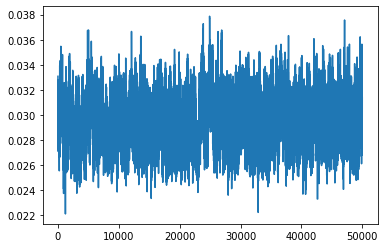

In [32]:
batch_loss_round_1_with_1e7score = []
c2st_metric_round_1_with_1e7score = []
sample_for_plot_round_1_with_1e7score = []
score_weight = 1e-7


params_nd = params_round_0
sample['thetas'] = sample['thetas'][:100]
sample['batch'] = sample['batch'][:100]
sample['score'] = sample['score'][:100]
sample['round'] = sample['round'][:100]

for rounds in [1,2]:

  ## create simulations
  if rounds == 0: 
    sample = {}
    thetas = None

  elif seq == 0 : 
    thetas = None


  @jax.jit
  def get_batch(key, batch_size=n_simulations):
      model = lotka_volterra
      (log_probs, samples), scores = get_samples_and_scores(model, key, batch_size=batch_size, score_type='conditional', thetas = thetas)
      return samples['theta'], samples['y'].reshape([-1,20], order='F'), scores

  thetas, batch, score = get_batch(jax.random.PRNGKey(rounds)) 

  # just in case..
  if jnp.isnan(score).any() == True:
    idx = jnp.where(jnp.isnan(score))[0]
    batch = jnp.delete(batch, idx, axis=0)
    thetas = jnp.delete(thetas, idx, axis=0)
    score = jnp.delete(score, idx, axis=0)

  if rounds == 0: 
    sample['thetas'] = thetas
    sample['batch'] = batch
    sample['score'] = score
    sample['round'] = jnp.repeat(rounds, len(score))
  else :
    sample['thetas'] = np.concatenate((sample['thetas'], thetas))
    sample['batch'] = np.concatenate((sample['batch'], batch))
    sample['score'] = np.concatenate((sample['score'], score))
    sample['round'] = np.concatenate((sample['round'], jnp.repeat(rounds, len(score))))


  # init parameters
  rng_seq = hk.PRNGSequence(model_seed)
  # if rounds == 0:
  #   params_nd = nvp_nd.init(next(rng_seq),  0.5*jnp.ones([1,4]), 0.5*jnp.ones([1,4]))

  # init optimizer
  scheduler = optax.exponential_decay(init_value=0.001, transition_steps=1000, decay_rate=0.9, end_value=0.00001)
  optimizer = optax.chain(optax.scale_by_adam(), optax.scale_by_schedule(scheduler), optax.scale(-1))
  opt_state = optimizer.init(params_nd)


  # train
  for step in tqdm(range(n_steps)): 
    inds = np.random.randint(0, len(sample['thetas']), batch_size) 
    
    inds_not_grad = jnp.where(sample['round'][inds] < start_grad)
    weight = np.repeat(score_weight, len(inds))
    weight[inds_not_grad] = 0

    l, params_nd, opt_state = update(params_nd, opt_state, weight, sample['thetas'][inds], sample['batch'][inds], sample['score'][inds])
    if jnp.isnan(l):
      break
    
    batch_loss_round_1_with_1e7score.append(l)

  #mcmc
  import tensorflow as tf
  with tf.device('/CPU:0'):
    def unnormalized_log_prob(x):
            likelihood = nvp_nd.apply(params_nd, x.reshape([-1, 4]), obs.reshape([-1, 4])).squeeze()
            prior = tfd.LogNormal(loc=jnp.array([-0.125,-3,-0.125,-3]),
                                  scale=jnp.array([0.5, 0.5, 0.5, 0.5])).log_prob(x).sum()
            return likelihood + prior

        
    sample_nd = []
    j = 0

    nb_simulations_needed = 10000
    if n_simulations > 10000: 
      nb_simulations_needed = n_simulations

    count = 0
    while len(sample_nd) < nb_simulations_needed :
      count+=1
      num_results_size = 5 + j
      # Initialize the HMC transition kernel.
      num_results = int(nb_simulations_needed * num_results_size) 
      num_burnin_steps = int(4e3)
      adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
          tfp.mcmc.HamiltonianMonteCarlo(
              target_log_prob_fn=unnormalized_log_prob,
              num_leapfrog_steps=3,
              step_size=0.01),
          num_adaptation_steps=int(num_burnin_steps * 0.8))

      # Run the chain (with burn-in).
      @jax.jit
      def run_chain():
        samples, is_accepted = tfp.mcmc.sample_chain(
            num_results=num_results,
            num_burnin_steps=num_burnin_steps,
            current_state=jnp.array(truth),
            kernel=adaptive_hmc,
            trace_fn=lambda _, pkr: pkr.inner_results.is_accepted,
            seed = jax.random.PRNGKey(j))
              
        return samples, is_accepted


      samples_hmc, is_accepted_hmc = run_chain()
      plt.clf()
      plt.plot(samples_hmc[:,0,1])
      plt.savefig('chain_round_%d' %rounds)

      sample_nd = samples_hmc[is_accepted_hmc].reshape([-1,4])

      if count > 5:
        break

      j += 5
        


  # compute metric c2st
  if len(sample_nd) > 10000 : 
     inds = np.random.randint(0, len(sample_nd),  10000) 
     sample_nd_for_c2st = sample_nd[inds,...]
      
  if len(sample_nd) > n_simulations : 
       inds = np.random.randint(0, len(sample_nd),  n_simulations) 
       thetas = sample_nd[inds,...]

  c2st_metric_round_1_with_1e7score.append(c2st(reference_samples, sample_nd_for_c2st, seed=0, n_folds=5))

  sample_for_plot_round_1_with_1e7score.append(sample_nd_for_c2st)

params_round3_with_1e7score = params_nd

Text(0.5, 1.0, 'loss nf round 1 and 2 with 1e-7 score')

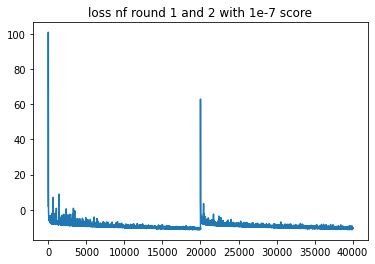

In [33]:
plt.plot(batch_loss_round_1_with_1e7score)
plt.title('loss nf round 1 and 2 with 1e-7 score')

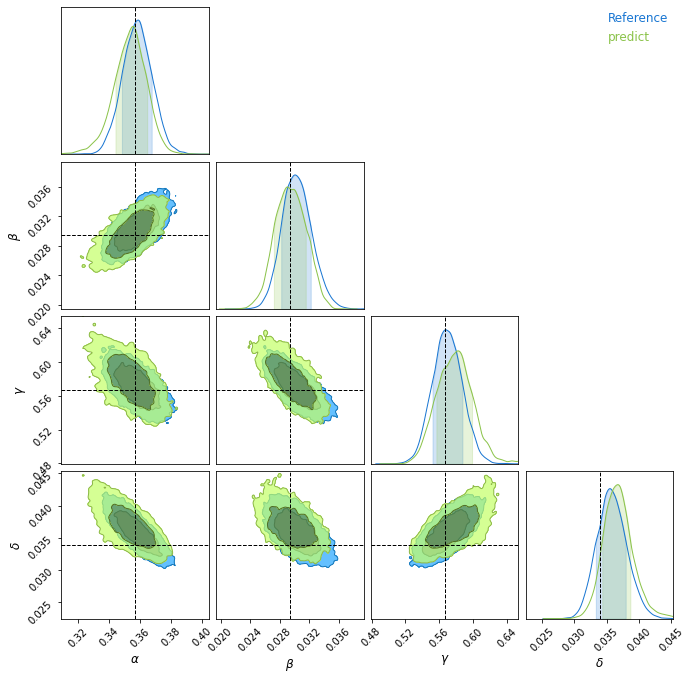

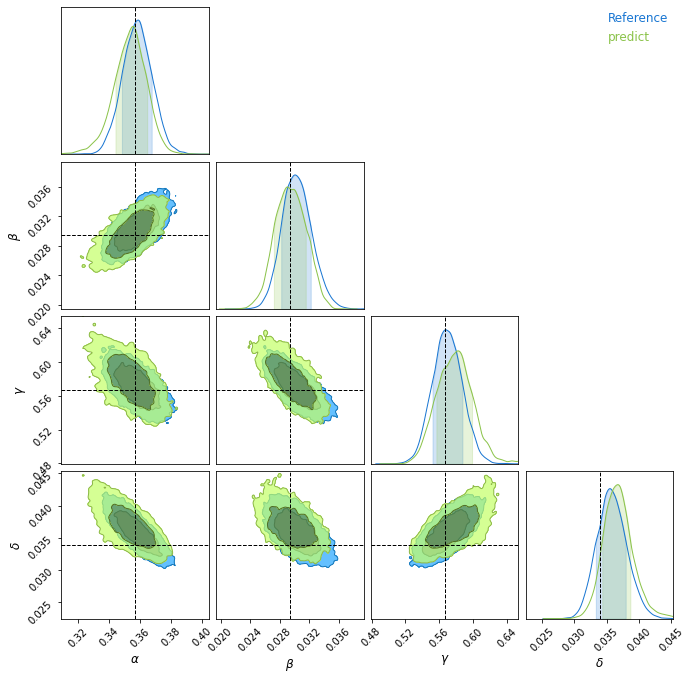

In [34]:
#plot second round with 1e-7 score
parameters = [r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\delta$']
c = ChainConsumer()
c.add_chain(jnp.array(reference_samples), parameters=parameters, name="Reference")
c.add_chain(sample_for_plot_round_1_with_1e7score[0], parameters=parameters, name="predict")
c.plotter.plot(
    figsize=[10, 10], 
    truth=np.array(truth)[0], 
    extents=[[t - 5 * np.std(reference_samples[:,i]), 
              t + 5 * np.std(reference_samples[:,i])] for i,t in enumerate(truth[0])]
  )

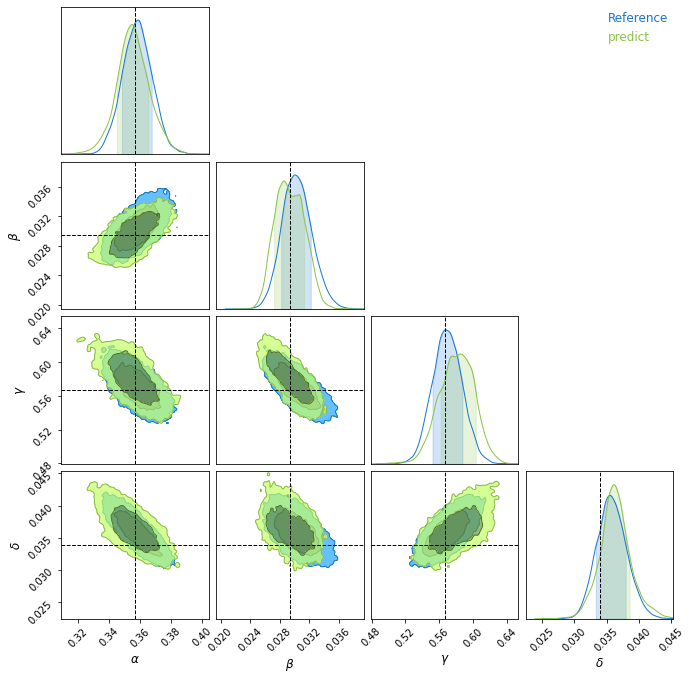

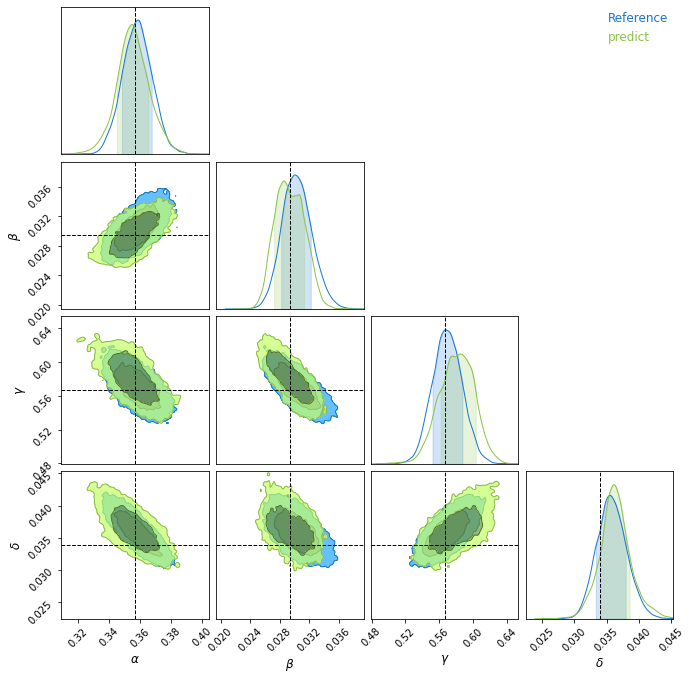

In [35]:
#plot third round with 1e-7 score
parameters = [r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\delta$']
c = ChainConsumer()
c.add_chain(jnp.array(reference_samples), parameters=parameters, name="Reference")
c.add_chain(sample_for_plot_round_1_with_1e7score[1], parameters=parameters, name="predict")
c.plotter.plot(
    figsize=[10, 10], 
    truth=np.array(truth)[0], 
    extents=[[t - 5 * np.std(reference_samples[:,i]), 
              t + 5 * np.std(reference_samples[:,i])] for i,t in enumerate(truth[0])]
  )

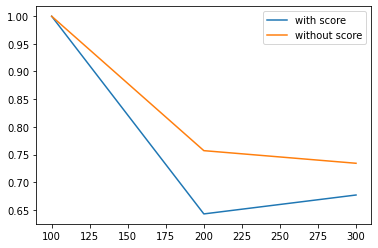

In [38]:
plt.plot([100,200,300],jnp.concatenate([jnp.array(c2st_metric_round_0), jnp.array(c2st_metric_round_1_with_1e7score)]),label = 'with score')
plt.plot([100,200,300],jnp.concatenate([jnp.array(c2st_metric_round_0), jnp.array(c2st_metric_round_1_without_score)]),label = 'without score')
plt.legend()